<a href="https://colab.research.google.com/github/akhsassoualid/KNN-for-mixed-data/blob/master/Prediction_of_making_a_deposit_by_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install prince

***1.***   ***Import the main important libraries to handle the analysis and the modeling of data***


In [0]:
# Imported libraries for dataframes, arrays, and plots
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to preprocess the data
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

# Libraries to transform categorical data
import prince # To run the FAMD

# Libraries for preprocessing, and modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Libraries for evaluation's metrics
from sklearn.metrics import f1_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [0]:
# Define Function
def explor(data):
    print(data.info())
    print(data.describe())
    print(data.head())
    print(data.tail())
    # detect missing values
    x = data.isnull().sum()
    # detect missing values
    if sum(x)==0:
        print('there are no missed values')
    else:
        for i in np.arange(0,len(x)):
            if x[i]!=0:
                print('there are '+str(x[i])+' missied value in the column '+ x.index[i])

In [0]:
df = pd.read_csv('/content/bank-additional-full.csv',sep=';', comment='#', na_values='NA')

***2.***   ***Import the data, first look on it, detect missing values, and explore visually the data***

In [11]:
df['y'] = [1 if df['y'][i]=='yes' else 0 for i in np.arange(0,len(df['y']),1)] # Recode the target variable
df.y=df.y.astype('object')
df = df.drop(['duration', 'poutcome'], axis=1) # drop unnecessary variables
explor(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(10)
memory usage: 6.0+ MB
None
               age      campaign  ...     euribor3m   nr.emplo

In [0]:
categorical_mask = (df.dtypes == 'object')

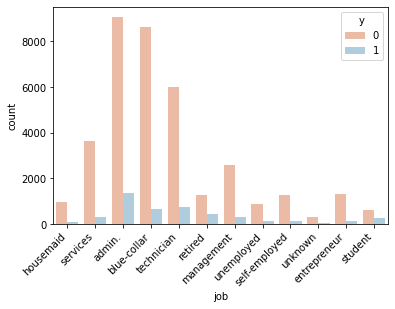

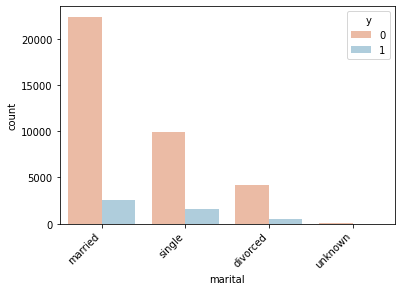

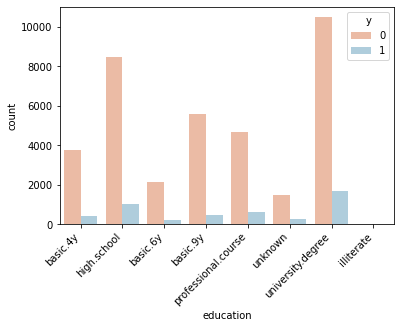

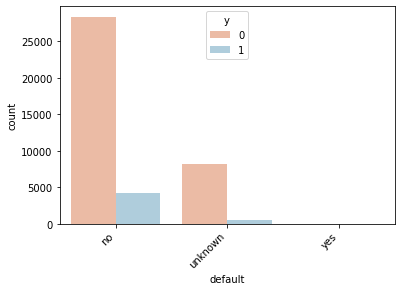

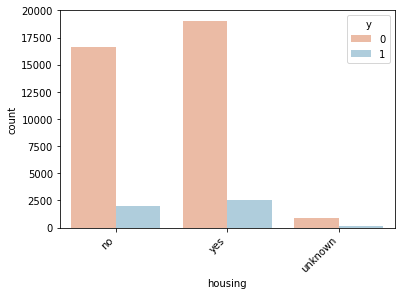

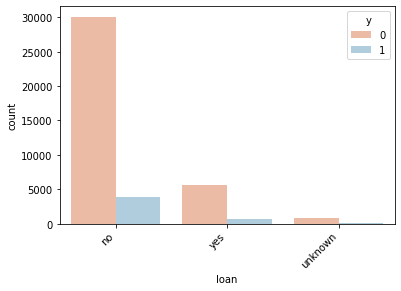

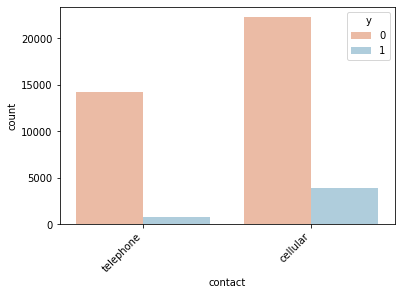

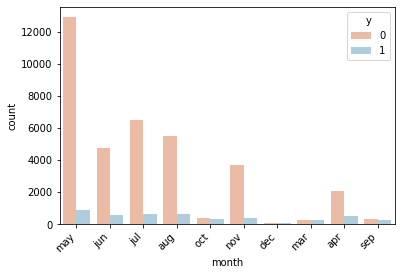

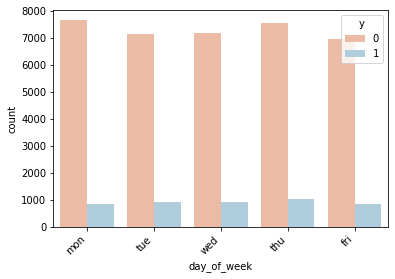

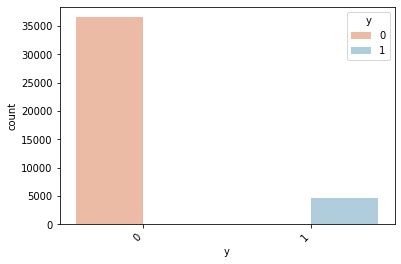

In [13]:
# Plot the distribution of categorical variables
for var in df.columns[categorical_mask]:
  chart = sns.countplot(x=var, hue='y', data = df, palette='RdBu')
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
  plt.show()

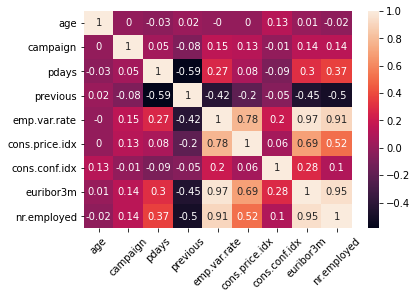

In [14]:
# Heatmap of correlation matrix between numeric variables
my_corr = df[df.columns[categorical_mask==False]].corr()
sns.heatmap(round(my_corr,2), annot = True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

***3.***   ***Scaling the data and splitting to train and test sets***

In [0]:
# Scale the continous variables 
scaler = StandardScaler()
cat_var = df.columns[categorical_mask==False].tolist()
df[cat_var] = scaler.fit_transform(df[cat_var])

***4.***   ***Fit a KNN Classifier without changing the type of categorical to integer ( Without using a lebel encoding of categorical data and convert them to integers):***




***4.1.***   ***Perform a Factor analysis of mixed data (FAMD):***




In [16]:
# Fix the number of components that cover a % of informations
def fit_famd(X, threshold, ncp):
  info = 0
  while info <= threshold:
    info = 0
    famd = prince.FAMD(n_components=ncp, n_iter=5, random_state=100)
    model = famd.fit(X)
    famd_feat = model.transform(X)
    info = info + sum(model.explained_inertia_)
    ncp = ncp+1
  print('The number of compoenents that cover '+str(round(info,2)*100)+'%'+'of informations is :{}'.format(ncp-1))
  famd_feat.columns = ['cp'+str(k) for k in range(0,ncp-1)]
  famd_feat.index = df.index
  return famd_feat
# Perform a dimensional reduction that cover 90% of df's information
famd_features = fit_famd(df.drop(labels='y', axis=1), threshold=0.9, ncp=8)
# Data to perform on a KNN Classifier
famd_features['y'] = df['y'] 

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

The number of compoenents that cover 91.0%of informations is :19


***4.2.***  *** Split the famd_features data to train and test sets:***

In [0]:
# Split the data to train and test sets
X = famd_features.drop('y', axis=1)
y = famd_features['y'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=100)

***4.2.***    ***Fit different type of classifiers***

***4.2.1***   ***Fit a KNN Classifier with a GridSearch***
   




In [0]:
# Build a function to run multiple models at once
def grid_model(estim, param, CV, X_tr, X_te, y_tr, y_te):
    gr_estimator= GridSearchCV(estimator = estim, param_grid = param, cv=CV, scoring = 'roc_auc')
    gr = gr_estimator.fit(X_tr, y_tr)
    model = gr.best_estimator_
    y_pred = model.predict(X_te)
    print("The BEST SCORE OF AREA UNDER THE CURVE of the grid search is:{}".format(round(gr.best_score_,2)))
    print("The BEST PARAMETERS are:{}".format(gr.best_params_))
    print("The ACCURACY based on best model's predictions is:{}".format(round(accuracy_score(y_test, y_pred),2)))
    print("The PRECISION RATE of the model is:{}".format(recall_score(y_te,y_pred)))
    print("The SENSITIVITY RATE of the model is:{}".format(f1_score(y_te, y_pred)))
    print(pd.DataFrame(confusion_matrix(y_te, y_pred), 
                       index = ['true negative', 'true positive'], columns=['predicted negative','predicted positive']))
    # Plot the ROC-Curve
    y_pred_prob = model.predict_proba(X_te)[:,1]
    fpr, tpr, threshold = roc_curve(y_te, y_pred_prob)
    plt.plot([0,1],[0,1], 'g--')
    plt.plot(fpr, tpr, label='The ROC-CURVE plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return y_pred

The BEST SCORE OF AREA UNDER THE CURVE of the grid search is:0.7
The BEST PARAMETERS are:{'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'uniform'}
The ACCURACY based on best model's predictions is:0.89
The PRECISION RATE of the model is:0.0022148394241417496
The SENSITIVITY RATE of the model is:0.004415011037527594
               predicted negative  predicted positive
true negative                7334                   1
true positive                 901                   2


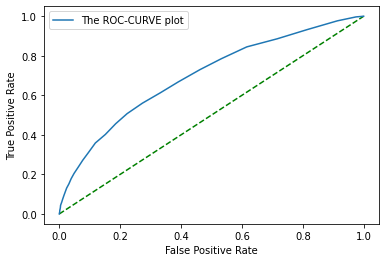

In [25]:
knn_param = {'n_neighbors':[10,20,45,65], 
             'weights':['uniform'],'metric':['manhattan']}
knn_pred = grid_model(KNeighborsClassifier(), knn_param, 10, X_train, X_test, y_train, y_test)


**Conclusion of KNN Classifier:**
*   The K Nearest Classifier model shows an accuracy of 89%, and an area under curve rate of 70% on test data. It seems that it's an impressive evaluation rate of the KNN model. However, if we take a look at the confusion matrix, precision, and sensitivity rates, we figure out that the model gives more importance to observations with a target variable class of 0 more than the other class. It seems it's a problem of unbalanced data.

